## Real-Time Prediction

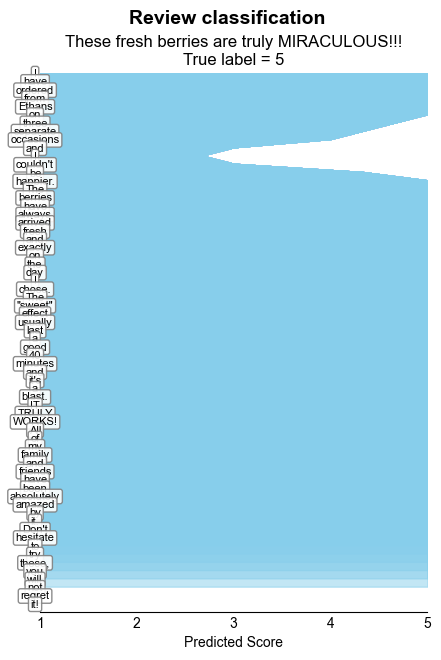

In [53]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# Set font to Arial
plt.rcParams['font.sans-serif'] = 'Arial'

# Load the fine-tuned model and tokenizer
model_directory = 'saved_model/fine_tuned_model'
model = AutoModelForSequenceClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-small-v2')

# Function to get the prediction for the current input text
def predict_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1).item()
    return predicted_class + 1  # Adjusting class index to 1-based scale

# Function to accumulate scores for each word added
def accumulate_scores(text_sequence, tokenizer, model):
    words = text_sequence.split()
    scores = []
    for i in range(1, len(words) + 1):
        current_text = ' '.join(words[:i])
        prediction = predict_text(current_text, tokenizer, model)
        scores.append(prediction)
    return scores

# Function to apply a simple moving average smoothing
def smooth(scores, window_size=3):
    return np.convolve(scores, np.ones(window_size) / window_size, mode='valid')

# Load your data
datafile_path = "../data/fine_food_reviews_with_embeddings_1k.csv"
df = pd.read_csv(datafile_path)

# Select a slice of rows for visualization
window = slice(6, 7)
subset_df = df[window]

# Initialize plot with more compact figure size
fig, ax = plt.subplots(figsize=(5, 7))
ax.set_xlim(1, 5)  # Assuming the scores range from 1 to 5
line, = ax.plot([], [], 'r-', marker='o')
true_score_text = ax.text(
    4.5, 
    0.5, 
    '', 
    ha='center',
    va='bottom', 
    fontsize=10,  # Reduced font size for true score text
    transform=ax.get_yaxis_transform()
)

# Calculate total frames and word lengths
word_lengths = [len(row['Text'].split()) for _, row in subset_df.iterrows()]
max_word_length = max(word_lengths)
total_frames = sum(word_lengths)

# Initialization function
def init():
    line.set_data([], [])
    true_score_text.set_text('')
    return line, true_score_text

# Animation function
def animate(frame):
    cumulative_frames = 0
    for i, length in enumerate(word_lengths):
        if frame < cumulative_frames + length:
            current_sentence = i
            current_word = frame - cumulative_frames
            break
        cumulative_frames += length

    row = subset_df.iloc[current_sentence]
    text_sequence = row['Text']
    true_score = row['Score']
    # summary
    summary = row['Summary']
    # take only first 10 words
    summary = ' '.join(summary.split()[:10])
    words = text_sequence.split()

    if current_word == 0:
        ax.clear()
        ax.set_xlim(1, 5)  # Adjusted for vertical alignment
        ax.set_ylim(len(words), 0)
        true_score_text.set_text(f'True Score: {true_score}')

    current_text = ' '.join(words[:current_word + 1])
    scores = accumulate_scores(current_text, tokenizer, model)

    # Ensure smoothing is applied only if there are enough points
    smoothed_scores = smooth(scores) if len(scores) >= 3 else scores
    y = range(len(smoothed_scores))
    x = smoothed_scores

    line.set_data(x, y)
    ax.fill_betweenx(y, 1, x, color='skyblue', alpha=0.5)
    ax.set_yticks(range(len(words[:current_word + 1])))
    ax.set_yticklabels(
        words[:current_word + 1], 
        rotation=0, 
        ha='center', 
        bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.2', alpha=0.9),
        fontsize=8  # Reduced font size for labels
    )

    # Set x-axis ticks to integers from 1 to 5
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels([1, 2, 3, 4, 5])
    ax.set_xlabel('Predicted Score', fontsize=10)  # Reduced font size for x-axis label

    # Disable upper and right axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set tick length to 0
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0)

    # Set title
    ax.set_title(f'{summary}\nScore = {true_score}', fontsize=12)
    fig.suptitle('Review classification', fontsize=14, y=0.97, fontweight='bold') 

    # Set x limit to 5
    ax.set_xlim(1, 5)

    return line, true_score_text

# Create the animation
ani = FuncAnimation(fig, animate, frames=total_frames, init_func=init, blit=True, repeat=False)
ani.save('sentiment_analysis.gif', writer=PillowWriter(fps=5), dpi=500)

plt.show()

## Gradio

In [67]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import gradio as gr
import numpy as np

# Set font to Arial
plt.rcParams['font.sans-serif'] = 'Arial'

# Load the fine-tuned model and tokenizer
model_directory = 'saved_model/fine_tuned_model'
model = AutoModelForSequenceClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-small-v2')

# Function to get the prediction for the current input text
def predict_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1).item()
    return predicted_class + 1  # Adjusting class index to 1-based scale

# Function to get sentiment prediction and scores for Gradio
def get_sentiment_prediction(text):
    return "" if not text.strip() else predict_text(text, tokenizer, model)

# Gradio interface
def predict_and_display(text):
    final_score = get_sentiment_prediction(text)
    return f"Text Sentiment Score: {final_score}"

iface = gr.Interface(
    fn=predict_and_display, 
    inputs=gr.Textbox(lines=2, placeholder="Enter text here...", label="Text Input"), 
    outputs=gr.Textbox(lines=2, label="Sentiment Score"),
    live=True,
    title="Real-time Sentiment Analysis",
    description="Enter text and see real-time sentiment predictions for the entire text.",
)

iface.launch()

Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.
